In [292]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [293]:
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, robust_scale
from sklearn import preprocessing
import seaborn as sns
from xgboost import XGBRegressor

import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import power_transform, quantile_transform

In [294]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\vlnlo\AppData\Roaming\Python\Python36\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'mean', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Combine data for preprocessing**

In [295]:
df = pd.read_csv(os.path.join('datasets', 'house-price-prediction', 'train.csv'))
df_test = pd.read_csv(os.path.join('datasets', 'house-price-prediction', 'test.csv'))

In [296]:
df['label'] = 'train'
df_test['label'] = 'test'
df = pd.concat([df, df_test], axis=0)

C:\Users\vlnlo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# EDA 

In [297]:
with open(os.path.join('datasets', 'house-price-prediction', 'data_description.txt'), 'r') as descr:
    print(descr.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## 1. Fill in missed values

In [298]:
numeric_cols = df.select_dtypes(['int64', 'float64']).columns
df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 38 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtUnfSF        2918 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2918 non-null float64
GarageCars       2918 non-null float64
GarageYrBlt      2760 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
Id               2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2433 non-null float64
LowQualFinSF     2919 non-null int64
MSSubClass       2919 non-null int64
MasVnrArea       2896 no

**Fill in missed numeric values**

In [299]:
missed_fts = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 
              'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageCars', 
              'GarageArea']
for missed_ft in missed_fts:
    df[missed_ft].fillna(df[missed_ft].mean(), inplace=True)

In [300]:
df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 38 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtUnfSF        2919 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2919 non-null float64
GarageCars       2919 non-null float64
GarageYrBlt      2919 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
Id               2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2919 non-null float64
LowQualFinSF     2919 non-null int64
MSSubClass       2919 non-null int64
MasVnrArea       2919 no

**Find missed string values**

In [301]:
str_cols = df.select_dtypes(['object']).columns
df[str_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 44 columns):
Alley            198 non-null object
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtQual         2838 non-null object
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
Fence            571 non-null object
FireplaceQu      1499 non-null object
Foundation       2919 non-null object
Functional       2917 non-null object
GarageCond       2760 non-null object
GarageFinish     2760 non-null object
GarageQual       2760 non-null object
GarageType       2762 non-null object
Heating          2919

In [302]:
round(100 * (df[str_cols].isnull().sum() / df[str_cols].index.shape[0]), 2)

Alley            93.22
BldgType          0.00
BsmtCond          2.81
BsmtExposure      2.81
BsmtFinType1      2.71
BsmtFinType2      2.74
BsmtQual          2.77
CentralAir        0.00
Condition1        0.00
Condition2        0.00
Electrical        0.03
ExterCond         0.00
ExterQual         0.00
Exterior1st       0.03
Exterior2nd       0.03
Fence            80.44
FireplaceQu      48.65
Foundation        0.00
Functional        0.07
GarageCond        5.45
GarageFinish      5.45
GarageQual        5.45
GarageType        5.38
Heating           0.00
HeatingQC         0.00
HouseStyle        0.00
KitchenQual       0.03
LandContour       0.00
LandSlope         0.00
LotConfig         0.00
LotShape          0.00
MSZoning          0.14
MasVnrType        0.82
MiscFeature      96.40
Neighborhood      0.00
PavedDrive        0.00
PoolQC           99.66
RoofMatl          0.00
RoofStyle         0.00
SaleCondition     0.00
SaleType          0.03
Street            0.00
Utilities         0.07
label      

**Drop features with missing percentage > 70%**

In [303]:
df.drop(['MiscFeature', 'Fence', 'PoolQC', 'Alley'], axis=1, inplace=True)

**Fill other string values**

In [304]:
other = df.select_dtypes(['object']).columns
for col in other:
    print(df[col].value_counts())

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64
TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64
Y    2723
N     196
Name: CentralAir, dtype: int64
Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64
Norm      2889
Feedr       13
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


**Columns GarageQual, GarageCond, FireplaceQu, BsmtQual, BsmtCond, KitchenQual contains marks from Poor to Excellent. 
Let's map this in range from 0 (NaN) to 5 (excellent)**

In [305]:
marks_map = {
    'Ex': 5, # Excellent
    'Gd': 4, # Good
    'TA': 3, # Typical
    'Fa': 2, # Fair
    'Po': 1, # Poor
    'NaN': 0
}

**Fill in missed values by mode**

In [306]:
marks_cols = ['GarageQual', 'GarageCond', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'KitchenQual']
for col in marks_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].map(marks_map)
df[marks_cols].head()

,GarageQual,GarageCond,FireplaceQu,BsmtQual,BsmtCond,KitchenQual
0,3,3,4,4,3,4
1,3,3,3,4,3,3
2,3,3,3,4,3,4
3,3,3,4,3,4,4
4,3,3,3,4,3,4


In [307]:
df[marks_cols].describe()

,GarageQual,GarageCond,FireplaceQu,BsmtQual,BsmtCond,KitchenQual
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,2.964371,2.972251,3.713943,3.560808,3.002741,3.510791
std,0.245797,0.230290,0.615691,0.695367,0.290339,0.662159
min,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
25%,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000
75%,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


**Fill nan's in other string columns**

In [308]:
for col in other:
    if not col in set(marks_cols):
        df[col].fillna(df[col].mode()[0], inplace=True)

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 78 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null int64
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null int64
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd      2919

## 2. Find out dependencies in data

In [310]:
numeric_cols = df.select_dtypes(['int64', 'float64']).columns
corr_mat = df[numeric_cols].corr()
corr_mat

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1stFlrSF,1.000000,-0.249823,0.044086,0.108418,0.079586,0.458056,0.084323,0.259725,0.010985,0.382007,...,0.479152,0.121900,0.605852,0.098381,0.391782,0.801608,0.227347,0.310814,0.242245,-0.013442
2ndFlrSF,-0.249823,1.000000,-0.032458,0.503506,-0.012858,-0.162284,-0.097734,-0.161434,-0.060269,0.131613,...,0.245596,0.044503,0.319334,0.011070,0.584586,-0.205643,0.089922,0.017588,0.158985,-0.019229
3SsnPorch,0.044086,-0.032458,1.000000,-0.048279,-0.023000,0.050908,-0.023279,0.027378,0.026861,0.016672,...,0.018715,-0.006525,0.044584,-0.029546,-0.025764,0.037892,-0.003935,0.015958,0.037433,0.022560
BedroomAbvGr,0.108418,0.503506,-0.048279,1.000000,-0.014178,-0.113526,-0.031217,-0.154991,0.018823,-0.052830,...,0.073075,0.036544,0.168213,0.007254,0.669737,0.053383,0.031644,-0.053101,-0.021912,-0.020453
BsmtCond,0.079586,-0.012858,-0.023000,-0.014178,1.000000,0.077178,0.072779,0.104770,0.036088,0.204565,...,0.169346,-0.000596,0.159445,-0.018750,0.016086,0.086413,0.102098,0.224232,0.138340,-0.038905
BsmtFinSF1,0.458056,-0.162284,0.050908,-0.113526,0.077178,1.000000,-0.055045,0.638744,0.078349,0.323082,...,0.281704,0.084462,0.386420,0.096821,0.052119,0.536467,0.223471,0.279547,0.152056,0.022556
BsmtFinSF2,0.084323,-0.097734,-0.023279,-0.031217,0.072779,-0.055045,1.000000,0.162832,0.099483,-0.051676,...,-0.042755,0.044524,-0.011378,0.063301,-0.048403,0.089410,0.098389,-0.027591,-0.062125,0.008883
BsmtFullBath,0.259725,-0.161434,0.027378,-0.154991,0.104770,0.638744,0.162832,1.000000,-0.148832,0.238888,...,0.164465,0.043970,0.227122,0.053117,-0.038844,0.325305,0.186072,0.211549,0.134878,0.045254
BsmtHalfBath,0.010985,-0.060269,0.026861,0.018823,0.036088,0.078349,0.099483,-0.148832,1.000000,-0.039036,...,-0.040713,0.066851,-0.016844,0.042067,-0.049518,0.012384,0.051539,-0.030278,-0.046261,-0.020028
BsmtQual,0.382007,0.131613,0.016672,-0.052830,0.204565,0.323082,-0.051676,0.238888,-0.039036,1.000000,...,0.678525,0.013222,0.650138,0.009833,0.232651,0.469498,0.266943,0.738841,0.589722,-0.007013


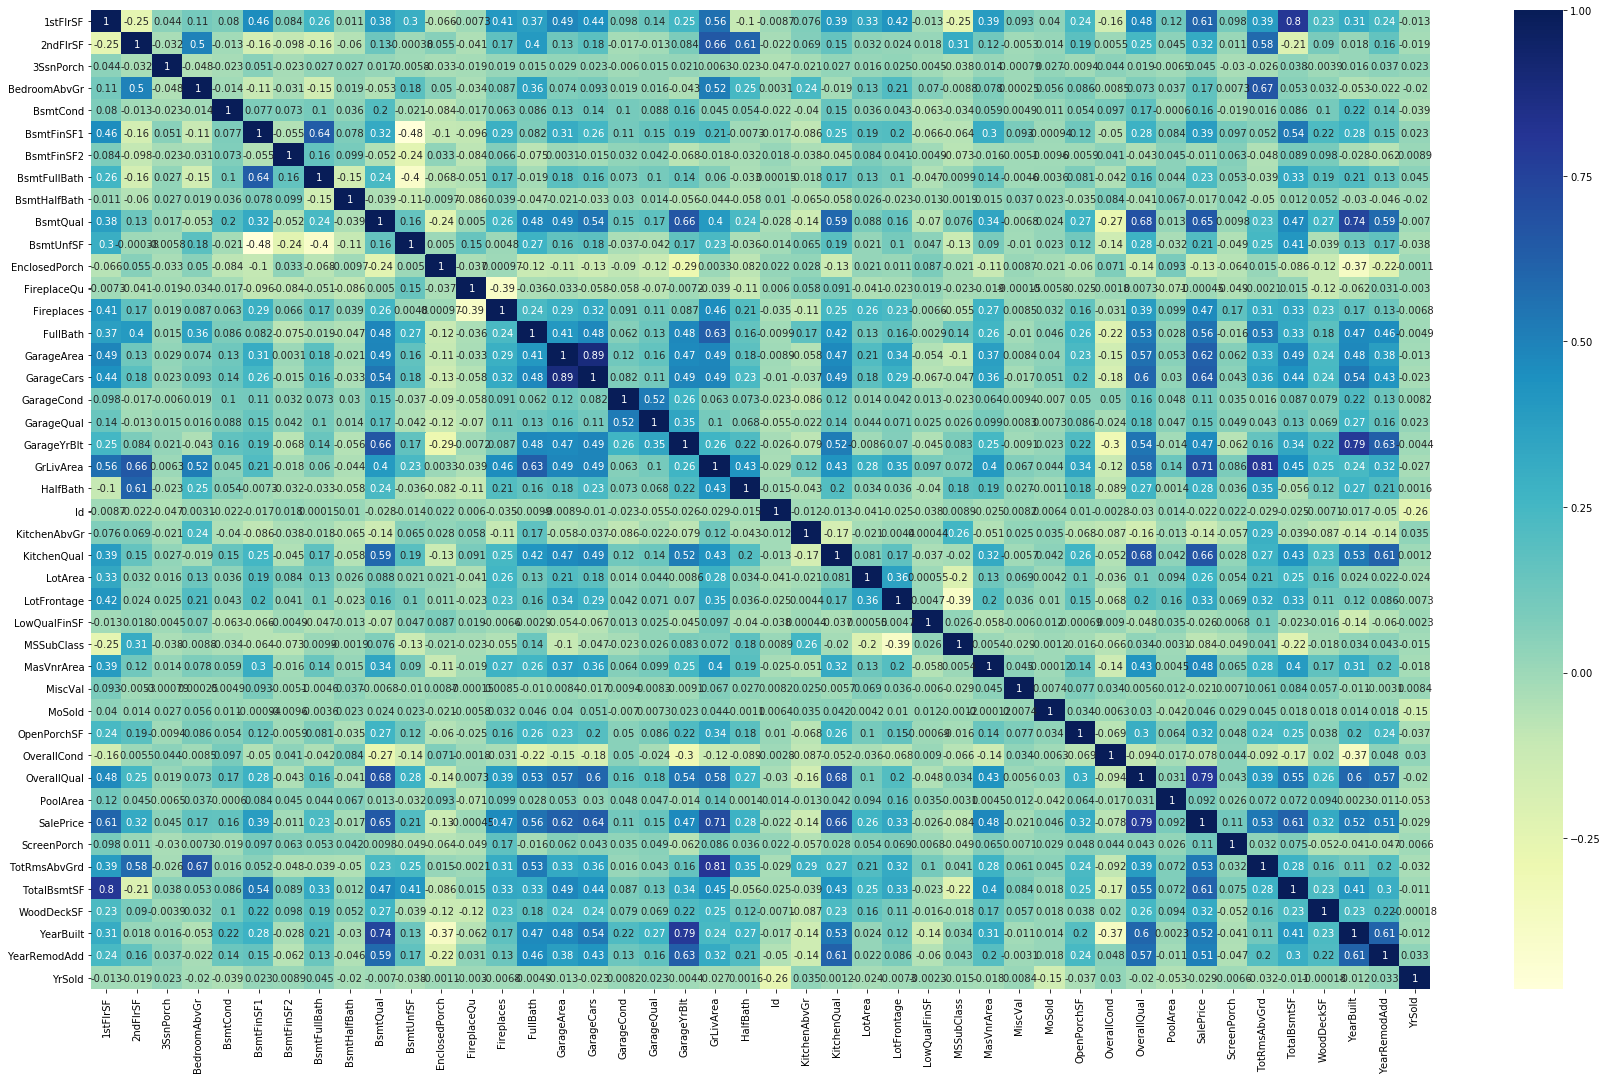

In [311]:
plt.figure(figsize=(30,18))
sns.heatmap(corr_mat, cmap="YlGnBu", annot=True)
plt.show()

From the above we conclude that:
* TotalBasementSF, 1stFlrSF independent variables are correlated, so we would consider only one - TotalBasementSF
* GarageYearBlt, YearBlt independent variables are correlated, so we would consider only one - YearBlt
* TotRmsAbvGrd, GrLivArea independent variables are correlated, so we would consider only one - GrLivArea
* FireplaceQu, Fireplaces independent variables are correlated, so we would consider only one - Fireplaces
* GarageQual, GarageCond independent variables are correlated, so we would consider only one - GarageQual
* GarageCars, GarageArea independent variables are correlated, so we would consider only one - GarageCars

SalePrice corrs with (>0.5):
* OverallQual
* GrLivArea
* YearBuilt
* YearRemodAdd
* BsmtQual
* TotalBsmtSF
* FullBath
* GarageCars

**Drop non-significant columns**

In [312]:
nonsgnfct = ['1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageCond', 'GarageArea']
# Add columns, that has no meaning or small correlation coef (<0.2)
nonsgnfct += ['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr',
              'KitchenAbvGr','GarageArea','3SsnPorch','ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
df.drop(nonsgnfct, axis=1, inplace=True)

**Look at the pair distribution between features and target**

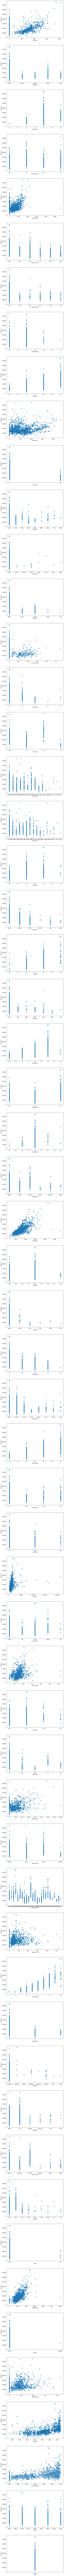

In [313]:
df_features = df.drop(['SalePrice'], axis=1)
feat_num = len(df_features.columns)
fig, ax = pylab.subplots(feat_num, 1, figsize=(10, 8 * feat_num))
for i, col in enumerate(df_features.columns):
    ax[i].scatter(df_features[col], df['SalePrice'])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('SalePrice')

It seems like SalePrice has:
* linear dependency with LandSlope 
* quadratic dependency with OverallQual
* linear with YearBuilt
* quadratic with BsmtQual
* linear with BsmtFinType1
* linear with BsmtUnfSF
* linear with TotalBsmtSF
* linear with HeatingQC 
* linear with 2ndFlrSF
* linear with GrLivArea
* linear with FullBath
* linear with GarageCars

In [314]:
# for col in ['BsmtQual', 'OverallQual', '2ndFlrSF', 'GrLivArea', 'FullBath', 'GarageCars',
#             'BsmtUnfSF']:
#     degrees = np.linspace(.1, 7, 80)
#     corrs = [df['SalePrice'].corr(df[col] ** degree) for degree in degrees]
#     best_degree = degrees[np.argmax(corrs)]
#     df[col + '_d'] = df[col] ** best_degree
#     print('Best degree for {} is {:.3f}'.format(col, best_degree))

## 3. Deskew features

C:\Users\vlnlo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vlnlo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


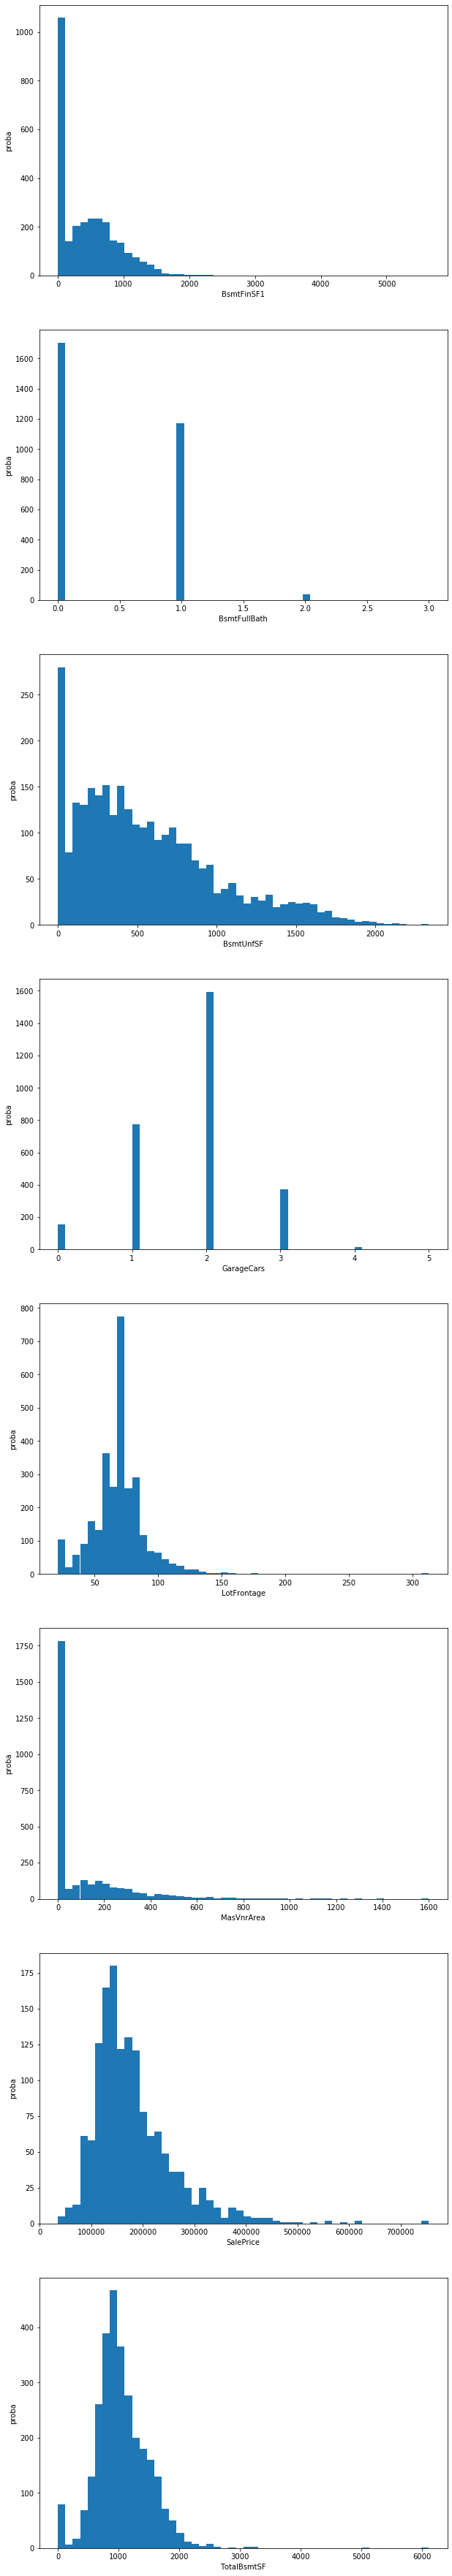

In [315]:
df_numeric = df.select_dtypes(['float64'])
feat_num = len(df_numeric.columns)
fig, ax = pylab.subplots(feat_num, 1, figsize=(10, 8 * feat_num))
for i in range(feat_num):
    ax[i].hist(df[df_numeric.columns[i]], bins=50)
    ax[i].set_xlabel(df_numeric.columns[i])
    ax[i].set_ylabel('proba')

**Some features have exponential distribution** 
* 2ndFlrSF
* BsmtFinSF1
* BsmtFullBath
* BsmtUnfSF
* EnclosedPorch
* MasVnrArea
* OpenPorchSF
* WoodDeckSF

**And other features are so skewed: GrLivArea, LotArea, LotFrontage, TotalBsmtSF. We will apply quantile transformation to descew features and make them more look like gaussian.**

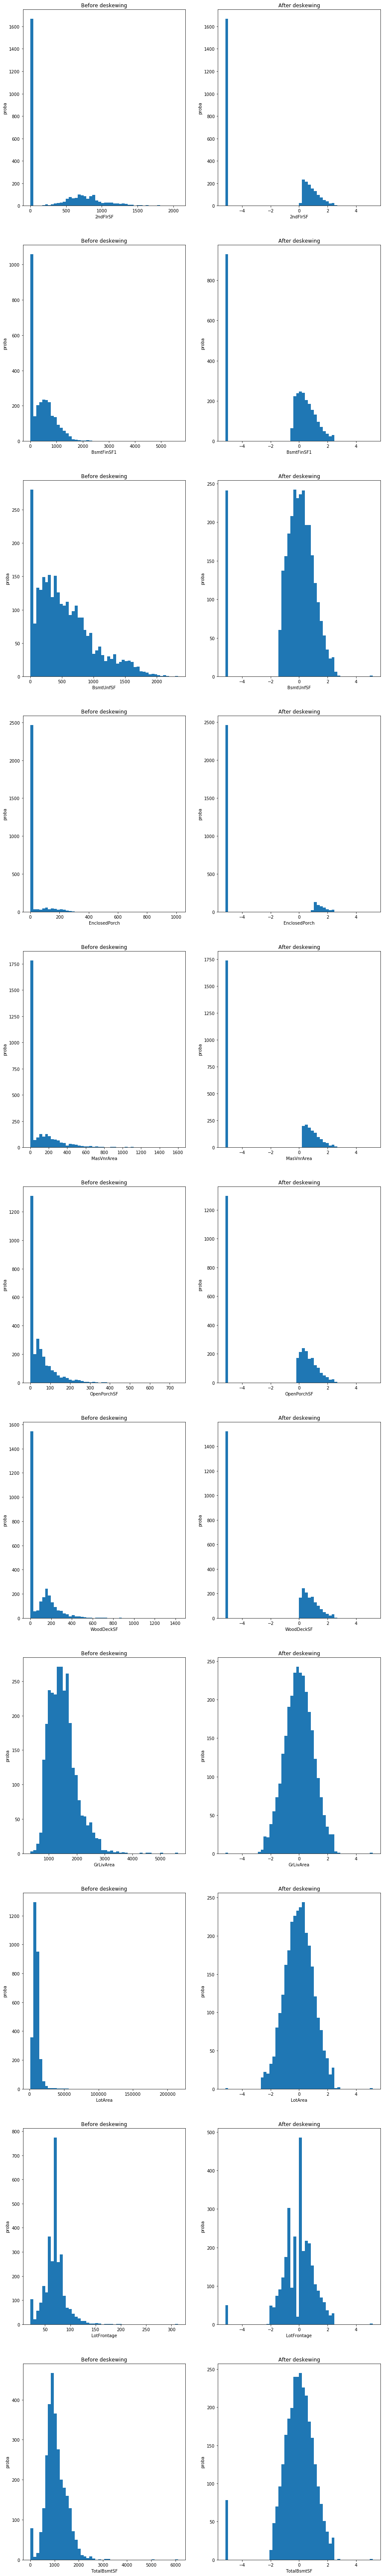

In [316]:
features_to_deskew = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'EnclosedPorch', 'MasVnrArea', 
                      'OpenPorchSF', 'WoodDeckSF', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
feat_num = len(features_to_deskew)
fig, ax = pylab.subplots(feat_num, 2, figsize=(15, 10 * feat_num))
for i, feat in enumerate(features_to_deskew):
    transformed = quantile_transform(df[feat].values.reshape(-1, 1), n_quantiles=100, random_state=0, 
                                 output_distribution='normal', copy=True)
    ax[i, 0].hist(df[feat].values, bins=50)
    ax[i, 0].set_xlabel(feat)
    ax[i, 0].set_ylabel('proba')
    ax[i, 0].set_title('Before deskewing')
    
    ax[i, 1].hist(transformed, bins=50)
    ax[i, 1].set_xlabel(feat)
    ax[i, 1].set_ylabel('proba')
    ax[i, 1].set_title('After deskewing')
    
    df[feat] = transformed.reshape(-1,)


**Now let's make bimodal distributed features unimodal by adding binary feature, that indicates whether feature is equal to 0 or not**

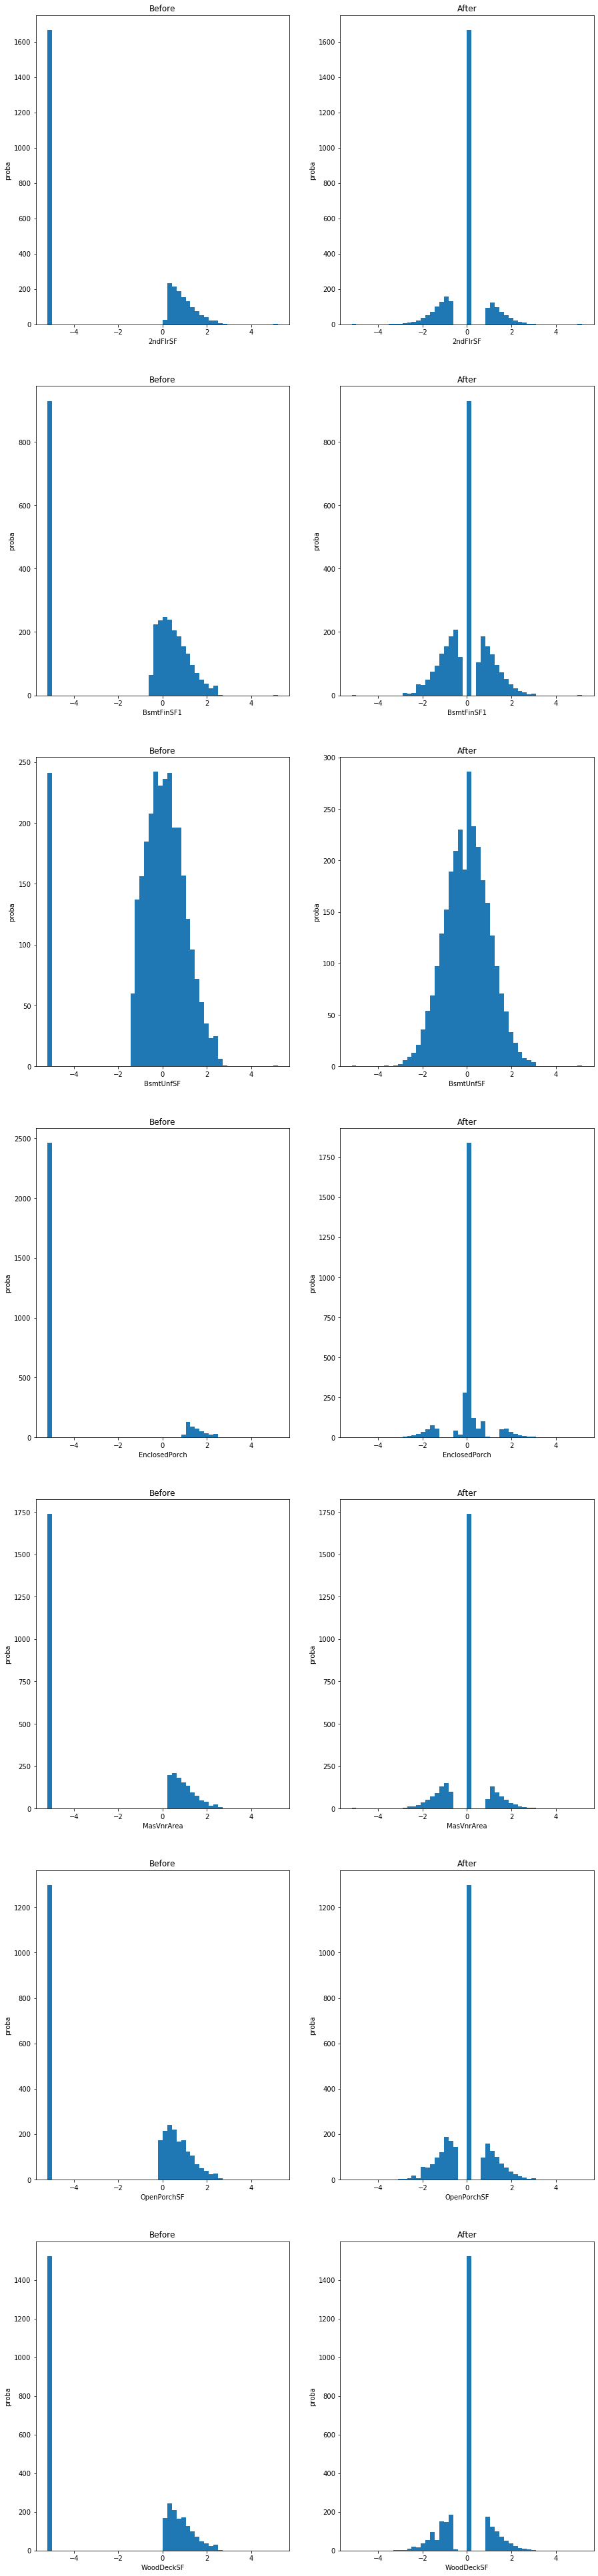

In [317]:
bimodal = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 
           'WoodDeckSF']
feat_num = len(bimodal)
fig, ax = pylab.subplots(feat_num, 2, figsize=(15, 10 * feat_num))
for i, feature in enumerate(bimodal):
    before = df[feature].values.copy()
    df[feature + '_ZEROFLAG'] = df[feature].apply(lambda x: 1 if x < -4 else 0)
    idxs = (df[feature + '_ZEROFLAG'] == 0)
    mean = df[idxs][feature].mean()
    df[feature] = df[feature].apply(lambda x: mean if x < -4 else x)
    df[feature] = quantile_transform(df[feature].values.reshape(-1, 1), n_quantiles=1000, random_state=0, 
                             output_distribution='normal', copy=True)

    ax[i, 0].hist(before, bins=50)
    ax[i, 0].set_xlabel(feature)
    ax[i, 0].set_ylabel('proba')
    ax[i, 0].set_title('Before')
    
    ax[i, 1].hist(df[feature], bins=50)
    ax[i, 1].set_xlabel(feature)
    ax[i, 1].set_ylabel('proba')
    ax[i, 1].set_title('After')

## 4. Remove outliers

**We will use IQR value to detect outliers, let's calculate it**

In [318]:
with_outliers = ['GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
Q1 = df[with_outliers].quantile(0.25)
Q3 = df[with_outliers].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

GrLivArea      1.342803
LotArea        1.353203
LotFrontage    1.286107
TotalBsmtSF    1.344038
dtype: float64


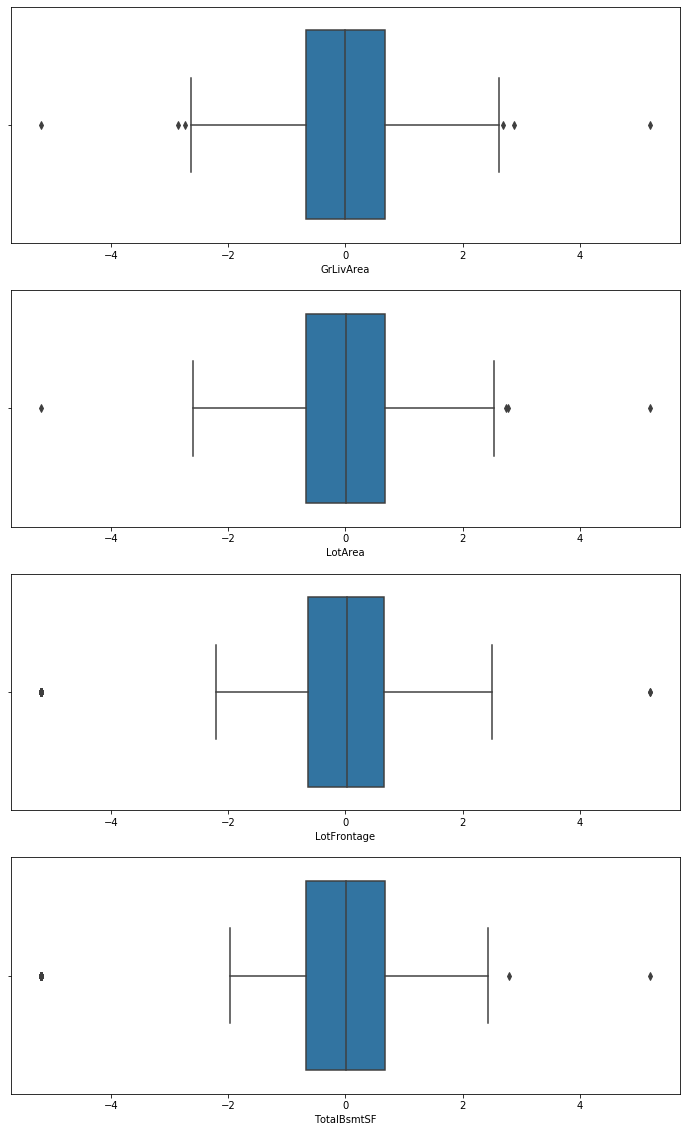

In [319]:
fig, ax = pylab.subplots(len(IQR.index), 1, figsize=(12, 5 * len(IQR.index)))
for i, column in enumerate(IQR.index):
    sns.boxplot(df[column], ax=ax[i])

In [320]:
df_train = df[df['label'] == 'train']
df_test = df[df['label'] == 'test']

filt = df_train['MasVnrArea'] == df_train['MasVnrArea']
for i, column in enumerate(IQR.index):
    filt = ~((df_train[column] < (Q1[i] - 1.5 * IQR[i])) | \
             (df_train[column] > (Q3[i] + 1.5 * IQR[i]))) & filt
    
df = pd.concat([df_train[filt], df_test], axis=0)
df.describe()

,2ndFlrSF,BsmtCond,BsmtFinSF1,BsmtFullBath,BsmtQual,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,...,YearBuilt,YearRemodAdd,YrSold,2ndFlrSF_ZEROFLAG,BsmtFinSF1_ZEROFLAG,BsmtUnfSF_ZEROFLAG,EnclosedPorch_ZEROFLAG,MasVnrArea_ZEROFLAG,OpenPorchSF_ZEROFLAG,WoodDeckSF_ZEROFLAG
count,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,...,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000
mean,0.005866,3.003508,0.000783,0.434535,3.568923,0.005875,0.015898,0.602946,1.570326,1.778943,...,1971.507190,1984.547176,2007.787092,0.572431,0.310768,0.069800,0.840407,0.593476,0.436689,0.517012
std,0.944084,0.292578,0.996071,0.523833,0.697667,1.012539,0.789926,0.644691,0.552712,0.756895,...,30.513032,20.849169,1.314930,0.494813,0.462889,0.254854,0.366293,0.491271,0.496063,0.499798
min,-5.199338,1.000000,-5.199338,0.000000,2.000000,-5.199338,-5.199338,0.000000,0.000000,0.000000,...,1872.000000,1950.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084155,3.000000,-0.675030,0.000000,3.000000,-0.677913,0.020074,0.000000,1.000000,1.000000,...,1954.000000,1965.000000,2007.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.084155,3.000000,0.095492,0.000000,4.000000,0.060256,0.031369,1.000000,2.000000,2.000000,...,1974.000000,1993.000000,2008.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,0.084155,3.000000,0.688500,1.000000,4.000000,0.691394,0.031369,1.000000,2.000000,2.000000,...,2001.000000,2004.000000,2009.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,5.199338,4.000000,3.118218,3.000000,5.000000,5.199338,5.199338,4.000000,4.000000,5.000000,...,2010.000000,2010.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [321]:
df.head(10)

,2ndFlrSF,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,BsmtUnfSF,...,YearRemodAdd,YrSold,label,2ndFlrSF_ZEROFLAG,BsmtFinSF1_ZEROFLAG,BsmtUnfSF_ZEROFLAG,EnclosedPorch_ZEROFLAG,MasVnrArea_ZEROFLAG,OpenPorchSF_ZEROFLAG,WoodDeckSF_ZEROFLAG
0,1.027225,1Fam,3,No,0.633317,GLQ,Unf,1.0,4,-1.321946,...,2003,2008,train,0,0,0,1,0,0,1
1,0.084155,1Fam,3,Gd,1.132492,ALQ,Unf,0.0,4,-0.731515,...,1976,2007,train,1,0,0,1,1,1,0
2,1.070745,1Fam,3,Mn,-0.645631,GLQ,Unf,1.0,4,-0.284828,...,2002,2008,train,0,0,0,1,0,0,1
3,-0.774833,1Fam,4,No,-1.353157,ALQ,Unf,1.0,3,-0.066541,...,1970,2006,train,0,0,0,0,1,0,1
4,1.497673,1Fam,3,Av,0.520661,GLQ,Unf,1.0,4,-0.158740,...,2000,2008,train,0,0,0,1,0,0,0
5,-1.339033,1Fam,3,No,0.670557,GLQ,Unf,1.0,4,-2.053336,...,1995,2009,train,0,0,0,1,1,0,0
6,0.084155,1Fam,3,Av,1.824556,GLQ,Unf,1.0,5,-0.624029,...,2005,2007,train,1,0,0,1,0,0,0
7,1.380815,1Fam,3,Mn,0.925213,ALQ,BLQ,1.0,4,-0.989697,...,1973,2009,train,0,0,0,0,0,0,0
8,-0.792012,1Fam,3,No,0.095492,Unf,Unf,0.0,3,0.949547,...,1950,2008,train,0,1,0,0,1,1,0
9,0.084155,2fmCon,3,No,0.914679,GLQ,Unf,1.0,3,-1.371657,...,1950,2008,train,1,0,0,1,1,0,1


In [322]:
df.shape

(2851, 66)

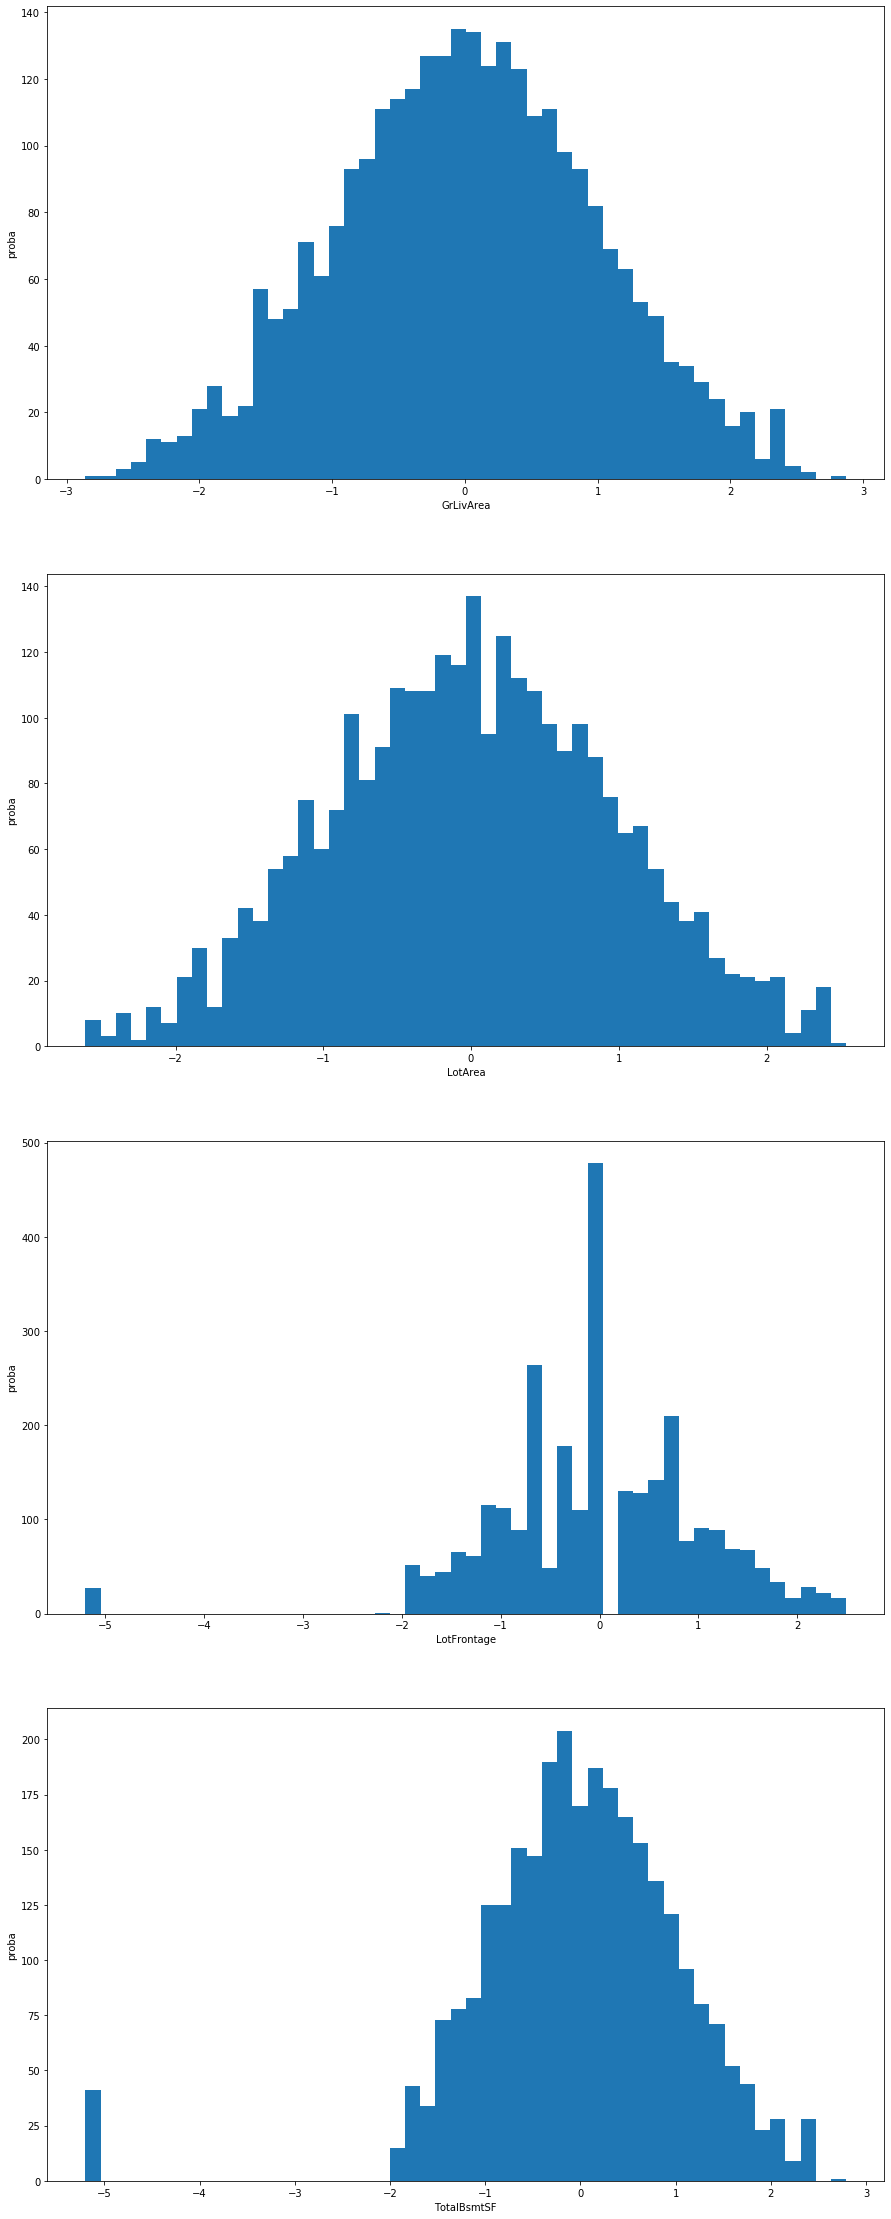

In [323]:
feat_num = len(IQR.index)
fig, ax = pylab.subplots(feat_num, figsize=(15, 10 * feat_num))
for i, feature in enumerate(IQR.index):
    ax[i].hist(df[feature], bins=50)
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('proba')

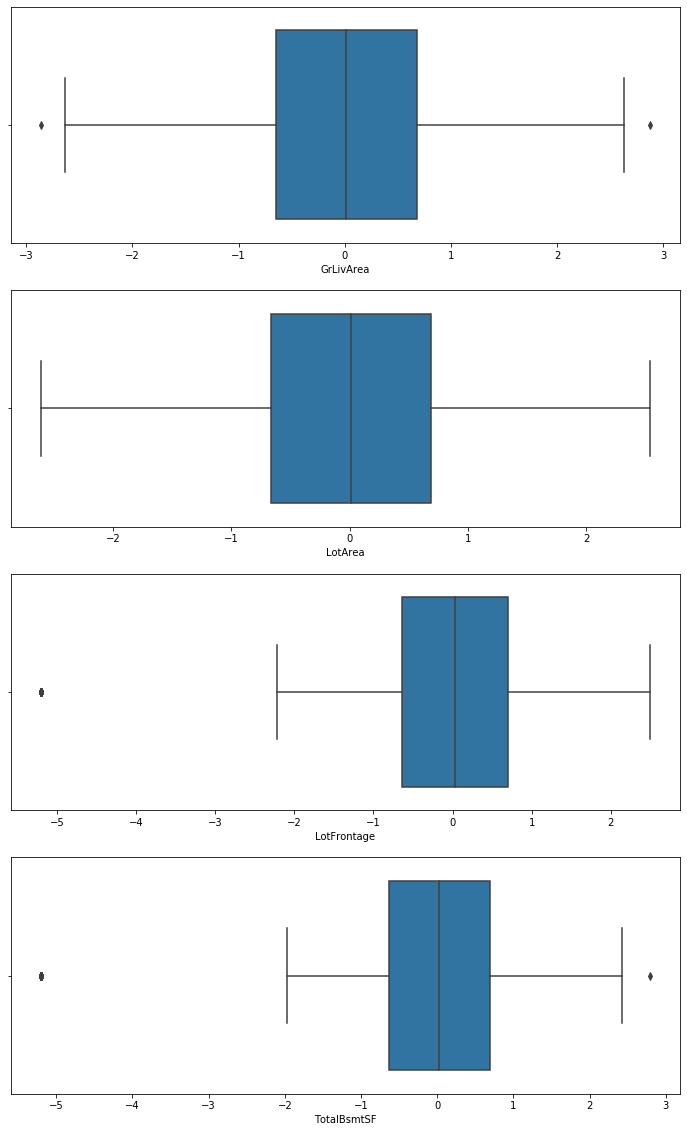

In [324]:
fig, ax = pylab.subplots(len(IQR.index), 1, figsize=(12, 5 * len(IQR.index)))
for i, column in enumerate(IQR.index):
    sns.boxplot(df[column], ax=ax[i])

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2851 entries, 0 to 1458
Data columns (total 66 columns):
2ndFlrSF                  2851 non-null float64
BldgType                  2851 non-null object
BsmtCond                  2851 non-null int64
BsmtExposure              2851 non-null object
BsmtFinSF1                2851 non-null float64
BsmtFinType1              2851 non-null object
BsmtFinType2              2851 non-null object
BsmtFullBath              2851 non-null float64
BsmtQual                  2851 non-null int64
BsmtUnfSF                 2851 non-null float64
CentralAir                2851 non-null object
Condition1                2851 non-null object
Condition2                2851 non-null object
Electrical                2851 non-null object
EnclosedPorch             2851 non-null float64
ExterCond                 2851 non-null object
ExterQual                 2851 non-null object
Exterior1st               2851 non-null object
Exterior2nd               2851 non-null obje

# Data preparation

In [326]:
X = df.drop(['SalePrice'], axis=1)
y = df[df['label'] == 'train']['SalePrice']

X_numeric = X.select_dtypes(['int64', 'float64'])
X_string = X.select_dtypes(['object'])

In [327]:
X_numeric

,2ndFlrSF,BsmtCond,BsmtFinSF1,BsmtFullBath,BsmtQual,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,...,YearBuilt,YearRemodAdd,YrSold,2ndFlrSF_ZEROFLAG,BsmtFinSF1_ZEROFLAG,BsmtUnfSF_ZEROFLAG,EnclosedPorch_ZEROFLAG,MasVnrArea_ZEROFLAG,OpenPorchSF_ZEROFLAG,WoodDeckSF_ZEROFLAG
0,1.027225,3,0.633317,1.0,4,-1.321946,0.031369,0,2,2.0,...,2003,2003,2008,0,0,0,1,0,0,1
1,0.084155,3,1.132492,0.0,4,-0.731515,0.031369,1,2,2.0,...,1976,1976,2007,1,0,0,1,1,1,0
2,1.070745,3,-0.645631,1.0,4,-0.284828,0.031369,1,2,2.0,...,2001,2002,2008,0,0,0,1,0,0,1
3,-0.774833,4,-1.353157,1.0,3,-0.066541,2.383724,1,1,3.0,...,1915,1970,2006,0,0,0,0,1,0,1
4,1.497673,3,0.520661,1.0,4,-0.158740,0.031369,1,2,3.0,...,2000,2000,2008,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-1.431971,3,0.095492,0.0,3,-0.051460,0.031369,0,1,0.0,...,1970,1970,2006,0,1,0,1,1,1,1
1455,-1.431971,3,-1.247505,0.0,3,-0.694311,0.031369,0,1,1.0,...,1970,1970,2006,0,0,0,1,1,0,1
1456,0.084155,3,1.554576,1.0,3,0.060256,0.031369,1,1,2.0,...,1960,1996,2006,1,0,1,1,1,1,0
1457,0.084155,3,-0.992177,0.0,4,0.216204,0.031369,0,1,0.0,...,1992,1992,2006,1,0,0,1,1,0,0


**Encode string columns**

In [328]:
X_string

,BldgType,BsmtExposure,BsmtFinType1,BsmtFinType2,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,...,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,label
0,1Fam,No,GLQ,Unf,Y,Norm,Norm,SBrkr,TA,Gd,...,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub,train
1,1Fam,Gd,ALQ,Unf,Y,Feedr,Norm,SBrkr,TA,TA,...,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub,train
2,1Fam,Mn,GLQ,Unf,Y,Norm,Norm,SBrkr,TA,Gd,...,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub,train
3,1Fam,No,ALQ,Unf,Y,Norm,Norm,SBrkr,TA,TA,...,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub,train
4,1Fam,Av,GLQ,Unf,Y,Norm,Norm,SBrkr,TA,Gd,...,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,Twnhs,No,Unf,Unf,Y,Norm,Norm,SBrkr,TA,TA,...,None,MeadowV,Y,CompShg,Gable,Normal,WD,Pave,AllPub,test
1455,TwnhsE,No,Rec,Unf,Y,Norm,Norm,SBrkr,TA,TA,...,None,MeadowV,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub,test
1456,1Fam,No,ALQ,Unf,Y,Norm,Norm,SBrkr,TA,TA,...,None,Mitchel,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub,test
1457,1Fam,Av,GLQ,Unf,Y,Norm,Norm,SBrkr,TA,TA,...,None,Mitchel,Y,CompShg,Gable,Normal,WD,Pave,AllPub,test


In [329]:
X_string = pd.get_dummies(X_string)
X_string

,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,label_test,label_train
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,1
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,1,0,0,1
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,1
3,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,1,0,0,1
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,1,0
1455,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,1,1,0,1,0
1456,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,1,1,0,1,0
1457,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0


In [330]:
X = pd.concat([X_numeric, X_string], axis=1)
X.head(8)

,2ndFlrSF,BsmtCond,BsmtFinSF1,BsmtFullBath,BsmtQual,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageCars,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,label_test,label_train
0,1.027225,3,0.633317,1.0,4,-1.321946,0.031369,0,2,2.0,...,0,0,0,1,0,1,1,0,0,1
1,0.084155,3,1.132492,0.0,4,-0.731515,0.031369,1,2,2.0,...,0,0,0,1,0,1,1,0,0,1
2,1.070745,3,-0.645631,1.0,4,-0.284828,0.031369,1,2,2.0,...,0,0,0,1,0,1,1,0,0,1
3,-0.774833,4,-1.353157,1.0,3,-0.066541,2.383724,1,1,3.0,...,0,0,0,1,0,1,1,0,0,1
4,1.497673,3,0.520661,1.0,4,-0.158740,0.031369,1,2,3.0,...,0,0,0,1,0,1,1,0,0,1
5,-1.339033,3,0.670557,1.0,4,-2.053336,0.031369,0,1,2.0,...,0,0,0,1,0,1,1,0,0,1
6,0.084155,3,1.824556,1.0,5,-0.624029,0.031369,1,2,2.0,...,0,0,0,1,0,1,1,0,0,1
7,1.380815,3,0.925213,1.0,4,-0.989697,1.994971,2,2,2.0,...,0,0,0,1,0,1,1,0,0,1


In [331]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2851 entries, 0 to 1458
Columns: 243 entries, 2ndFlrSF to label_train
dtypes: float64(13), int64(18), uint8(212)
memory usage: 1.3 MB


**Scale data**

In [332]:
unused = ['label_train', 'label_test']
X_train, X_test = X[X['label_train'] == 1].drop(unused, axis=1), \
                  X[X['label_test'] == 1].drop(unused, axis=1)
#X_train, X_test = robust_scale(X_train), robust_scale(X_test)

### Tune XGBRegressor hyperparameters

In [333]:
sample = pd.read_csv(os.path.join('datasets', 'house-price-prediction', 'sample_submission.csv'))
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


**Make rmse scoring callback**

In [334]:
rmse = lambda x, y: mean_squared_error(np.log(x), np.log(y)) ** .5
rmse_scoring = make_scorer(rmse, greater_is_better=False)

**Create model and look at the params**

In [335]:
xgbr = XGBRegressor(base_score=.25, n_jobs=-1, random_state=0)
xgbr.get_params()

{'base_score': 0.25,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [336]:
def result_report(gs):
    cv_results = zip(gs.cv_results_['params'], 
    gs.cv_results_['mean_test_score'], 
    gs.cv_results_['std_test_score'])
    for record in cv_results:
        print('mean: {:.5f}, std: {:.5f}, {}'.format(record[1], record[2], record[0])\
              .replace('{', '').replace('}', ''))
    print('RMSE: {:.6f}\nparams: {}'.format(gs.best_score_, gs.best_params_))

### Fix learning rate and find optimal value of n_estimators parameter

In [337]:
grid_1 = {
    'n_estimators': np.linspace(100, 1000, 15).astype(int)
}
gs_n_est = GridSearchCV(xgbr, grid_1, scoring=rmse_scoring, cv=5, n_jobs=-1)
gs_n_est

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': array([ 100,  164,  228,  292,  357,  421,  485,  550,  614,  678,  742,
        807,  871,

In [338]:
gs_n_est.fit(X_train, y)

C:\Users\vlnlo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\vlnlo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:53:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': array([ 100,  164,  228,  292,  357,  421,  485,  550,  614,  678,  742,
        807,  871,

In [339]:
result_report(gs_n_est)

mean: -0.12992, std: 0.00532, 'n_estimators': 100
mean: -0.12768, std: 0.00588, 'n_estimators': 164
mean: -0.12731, std: 0.00605, 'n_estimators': 228
mean: -0.12733, std: 0.00602, 'n_estimators': 292
mean: -0.12753, std: 0.00604, 'n_estimators': 357
mean: -0.12771, std: 0.00627, 'n_estimators': 421
mean: -0.12773, std: 0.00635, 'n_estimators': 485
mean: -0.12781, std: 0.00651, 'n_estimators': 550
mean: -0.12768, std: 0.00672, 'n_estimators': 614
mean: -0.12759, std: 0.00681, 'n_estimators': 678
mean: -0.12767, std: 0.00704, 'n_estimators': 742
mean: -0.12781, std: 0.00728, 'n_estimators': 807
mean: -0.12786, std: 0.00727, 'n_estimators': 871
mean: -0.12804, std: 0.00727, 'n_estimators': 935
mean: -0.12818, std: 0.00731, 'n_estimators': 1000
RMSE: -0.127311
params: {'n_estimators': 228}


**Try closer values**

In [340]:
grid_1_closer = {
    'n_estimators': np.linspace(200, 250, 15).astype(int)
}
gs1 = GridSearchCV(gs_n_est.best_estimator_, grid_1_closer, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs1.fit(X_train, y)
result_report(gs1)

[16:55:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean: -0.12732, std: 0.00596, 'n_estimators': 200
mean: -0.12731, std: 0.00591, 'n_estimators': 203
mean: -0.12731, std: 0.00591, 'n_estimators': 207
mean: -0.12732, std: 0.00592, 'n_estimators': 210
mean: -0.12726, std: 0.00603, 'n_estimators': 214
mean: -0.12736, std: 0.00601, 'n_estimators': 217
mean: -0.12743, std: 0.00597, 'n_estimators': 221
mean: -0.12741, std: 0.00605, 'n_estimators': 225
mean: -0.12731, std: 0.00605, 'n_estimators': 228
mean: -0.12738, std: 0.00594, 'n_estimators': 232
mean: -0.12743, std: 0.00598, 'n_estimators': 235
mean: -0.12749, std: 0.00589, 'n_estimators': 239
mean: -0.12756, std: 0.00593, 'n_estimators': 242
mean: -0.12752, std: 0.00589, 'n_estimators': 246
mean: -0.12753, std: 0.00580, 'n_estimators': 250
RMSE: -0.127262
params: {'n_estimators': 214}


### max_depth & min_child_weight

In [341]:
grid_2 = {
    'max_depth': range(1, 9),
    'min_child_weight': range(1,7)
}
gs_2 = GridSearchCV(gs1.best_estimator_, grid_2, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_2

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 9),
                         'min_child_weight': range(1, 7)},
             pre_dispa

In [342]:
gs_2.fit(X_train, y)

[17:00:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 9),
                         'min_child_weight': range(1, 7)},
             pre_dispa

In [343]:
result_report(gs_2)

mean: -0.14078, std: 0.00603, 'max_depth': 1, 'min_child_weight': 1
mean: -0.14076, std: 0.00603, 'max_depth': 1, 'min_child_weight': 2
mean: -0.14050, std: 0.00576, 'max_depth': 1, 'min_child_weight': 3
mean: -0.14122, std: 0.00565, 'max_depth': 1, 'min_child_weight': 4
mean: -0.14128, std: 0.00650, 'max_depth': 1, 'min_child_weight': 5
mean: -0.14106, std: 0.00621, 'max_depth': 1, 'min_child_weight': 6
mean: -0.12850, std: 0.00408, 'max_depth': 2, 'min_child_weight': 1
mean: -0.12853, std: 0.00380, 'max_depth': 2, 'min_child_weight': 2
mean: -0.12798, std: 0.00374, 'max_depth': 2, 'min_child_weight': 3
mean: -0.12811, std: 0.00573, 'max_depth': 2, 'min_child_weight': 4
mean: -0.12818, std: 0.00609, 'max_depth': 2, 'min_child_weight': 5
mean: -0.12805, std: 0.00519, 'max_depth': 2, 'min_child_weight': 6
mean: -0.12726, std: 0.00603, 'max_depth': 3, 'min_child_weight': 1
mean: -0.12668, std: 0.00642, 'max_depth': 3, 'min_child_weight': 2
mean: -0.12643, std: 0.00541, 'max_depth': 3, 'm

### gamma

In [344]:
grid_3 = {
    'gamma': np.linspace(.1, .4, 4)
}
gs_3 = GridSearchCV(gs_2.best_estimator_, grid_3, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_3

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': array([0.1, 0.2, 0.3, 0.4])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [345]:
gs_3.fit(X_train, y)

[17:01:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': array([0.1, 0.2, 0.3, 0.4])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [346]:
result_report(gs_3)

mean: -0.12643, std: 0.00541, 'gamma': 0.1
mean: -0.12643, std: 0.00541, 'gamma': 0.2
mean: -0.12643, std: 0.00541, 'gamma': 0.30000000000000004
mean: -0.12643, std: 0.00541, 'gamma': 0.4
RMSE: -0.126427
params: {'gamma': 0.1}


### subsample & colsample_bytree

In [347]:
grid_4 = {
 'subsample': np.arange(.5, 1, .1),
 'colsample_bytree': np.arange(.5, 1, .1)
}
gs_4 = GridSearchCV(gs_3.best_estimator_, grid_4, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_4

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'subsample': array([0.5, 0

In [348]:
gs_4.fit(X_train, y)

[17:02:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'subsample': array([0.5, 0

In [349]:
result_report(gs_4)

mean: -0.12657, std: 0.00601, 'colsample_bytree': 0.5, 'subsample': 0.5
mean: -0.12423, std: 0.00739, 'colsample_bytree': 0.5, 'subsample': 0.6
mean: -0.12584, std: 0.00703, 'colsample_bytree': 0.5, 'subsample': 0.7
mean: -0.12659, std: 0.00757, 'colsample_bytree': 0.5, 'subsample': 0.7999999999999999
mean: -0.12390, std: 0.00609, 'colsample_bytree': 0.5, 'subsample': 0.8999999999999999
mean: -0.12625, std: 0.00666, 'colsample_bytree': 0.6, 'subsample': 0.5
mean: -0.12172, std: 0.00652, 'colsample_bytree': 0.6, 'subsample': 0.6
mean: -0.12476, std: 0.00690, 'colsample_bytree': 0.6, 'subsample': 0.7
mean: -0.12511, std: 0.00775, 'colsample_bytree': 0.6, 'subsample': 0.7999999999999999
mean: -0.12640, std: 0.00704, 'colsample_bytree': 0.6, 'subsample': 0.8999999999999999
mean: -0.12753, std: 0.00829, 'colsample_bytree': 0.7, 'subsample': 0.5
mean: -0.12414, std: 0.00641, 'colsample_bytree': 0.7, 'subsample': 0.6
mean: -0.12582, std: 0.00837, 'colsample_bytree': 0.7, 'subsample': 0.7
mean

### reg_alpha & reg_lambda

In [350]:
grid_5 = {
 'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gs_5 = GridSearchCV(gs_4.best_estimator_, grid_5, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_5

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.6, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [351]:
gs_5.fit(X_train, y)

[17:03:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.6, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [352]:
result_report(gs_5)

mean: -0.12172, std: 0.00652, 'reg_alpha': 1e-05
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.01
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.1
mean: -0.12172, std: 0.00652, 'reg_alpha': 1
mean: -0.12201, std: 0.00704, 'reg_alpha': 100
RMSE: -0.121724
params: {'reg_alpha': 1e-05}


**Try closer values**

In [353]:
grid_5 = {
 'reg_alpha': np.linspace(0, 1, 20)
}
gs_5 = GridSearchCV(gs_4.best_estimator_, grid_5, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_5.fit(X_train, y)
result_report(gs_5)

[17:04:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.0
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.05263157894736842
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.10526315789473684
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.15789473684210525
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.21052631578947367
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.2631578947368421
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.3157894736842105
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.3684210526315789
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.42105263157894735
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.47368421052631576
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.5263157894736842
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.5789473684210527
mean: -0.12172, std: 0.00652, 'reg_alpha': 0.631578947368421
mean: -0.12172, std: 0.00652, 'reg_alpha

**Tune reg_lambda**

In [354]:
grid_5 = {
 'reg_lambda': np.linspace(.5, 1, 20)
}
gs_5 = GridSearchCV(gs_5.best_estimator_, grid_5, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_5.fit(X_train, y)
result_report(gs_5)

[17:05:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean: -0.12413, std: 0.00739, 'reg_lambda': 0.5
mean: -0.12340, std: 0.00780, 'reg_lambda': 0.5263157894736842
mean: -0.12247, std: 0.00710, 'reg_lambda': 0.5526315789473684
mean: -0.12375, std: 0.00687, 'reg_lambda': 0.5789473684210527
mean: -0.12401, std: 0.00676, 'reg_lambda': 0.6052631578947368
mean: -0.12303, std: 0.00768, 'reg_lambda': 0.631578947368421
mean: -0.12324, std: 0.00767, 'reg_lambda': 0.6578947368421053
mean: -0.12299, std: 0.00710, 'reg_lambda': 0.6842105263157895
mean: -0.12314, std: 0.00712, 'reg_lambda': 0.7105263157894737
mean: -0.12256, std: 0.00689, 'reg_lambda': 0.7368421052631579
mean: -0.12290, std: 0.00701, 'reg_lambda': 0.763157894736842
mean: -0.12176, std: 0.00688, 'reg_lambda': 0.7894736842105263
mean: -0.12169, std: 0.00731, 'reg_lambda': 0.8157894736842105
mean: -0.12218, std: 0.00633, 'reg

### Try decreasing regularization parameter learning_rate 

In [355]:
grid_6 = {
 'learning_rate': [.1, .01, .001, .0001, .00001]
}
gs_6 = GridSearchCV(gs_5.best_estimator_, grid_6, cv=5, scoring=rmse_scoring, n_jobs=-1)
gs_6

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.6, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0.9473684210526315,
                                    reg_lambda=0.8157894736842105,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.

In [356]:
gs_6.fit(X_train, y)

[17:06:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.25, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.6, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=3, missing=None,
                                    n_estimators=214, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0.9473684210526315,
                                    reg_lambda=0.8157894736842105,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.6, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.

In [357]:
result_report(gs_6)

mean: -0.12169, std: 0.00731, 'learning_rate': 0.1
mean: -0.18536, std: 0.00655, 'learning_rate': 0.01
mean: -1.63218, std: 0.00930, 'learning_rate': 0.001
mean: -3.83453, std: 0.00952, 'learning_rate': 0.0001
mean: -6.12511, std: 0.00963, 'learning_rate': 1e-05
RMSE: -0.121689
params: {'learning_rate': 0.1}


**Submit predictions**

In [358]:
sub_df = pd.DataFrame()
sub_df['id'] = sample['Id']
sub_df['SalePrice'] = gs_6.best_estimator_.predict(X_test)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,id,SalePrice
0,1461,117377.625000
1,1462,159510.968750
2,1463,185372.640625
3,1464,187474.140625
4,1465,183862.281250
